<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#005097; border:0' role="tab" aria-controls="home"><center>APRENDIZADO DE MÁQUINA (CIC1205/GCC1932) - Trabalho 1</center></h1>

- Nome completo: <ALEXANDER_RAMOS_FEITOSA>
- [Link para vídeo](<LINK_VIDEO>)

# (1) Predição de pagamento de empréstimos

### Análise exploratória dos conjuntos de treino e teste

=== Análise dos Conjuntos de Dados ===

Informações do conjunto de treinamento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ESCT     1500 non-null   int64
 1   NDEP     1500 non-null   int64
 2   RENDA    1500 non-null   int64
 3   TIPOR    1500 non-null   int64
 4   VBEM     1500 non-null   int64
 5   NPARC    1500 non-null   int64
 6   VPARC    1500 non-null   int64
 7   TEL      1500 non-null   int64
 8   IDADE    1500 non-null   int64
 9   RESMS    1500 non-null   int64
 10  ENTRADA  1500 non-null   int64
 11  CLASSE   1500 non-null   int64
dtypes: int64(12)
memory usage: 140.8 KB
None

Informações do conjunto de teste:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ESCT     577 non-null    int64
 1   NDEP     5

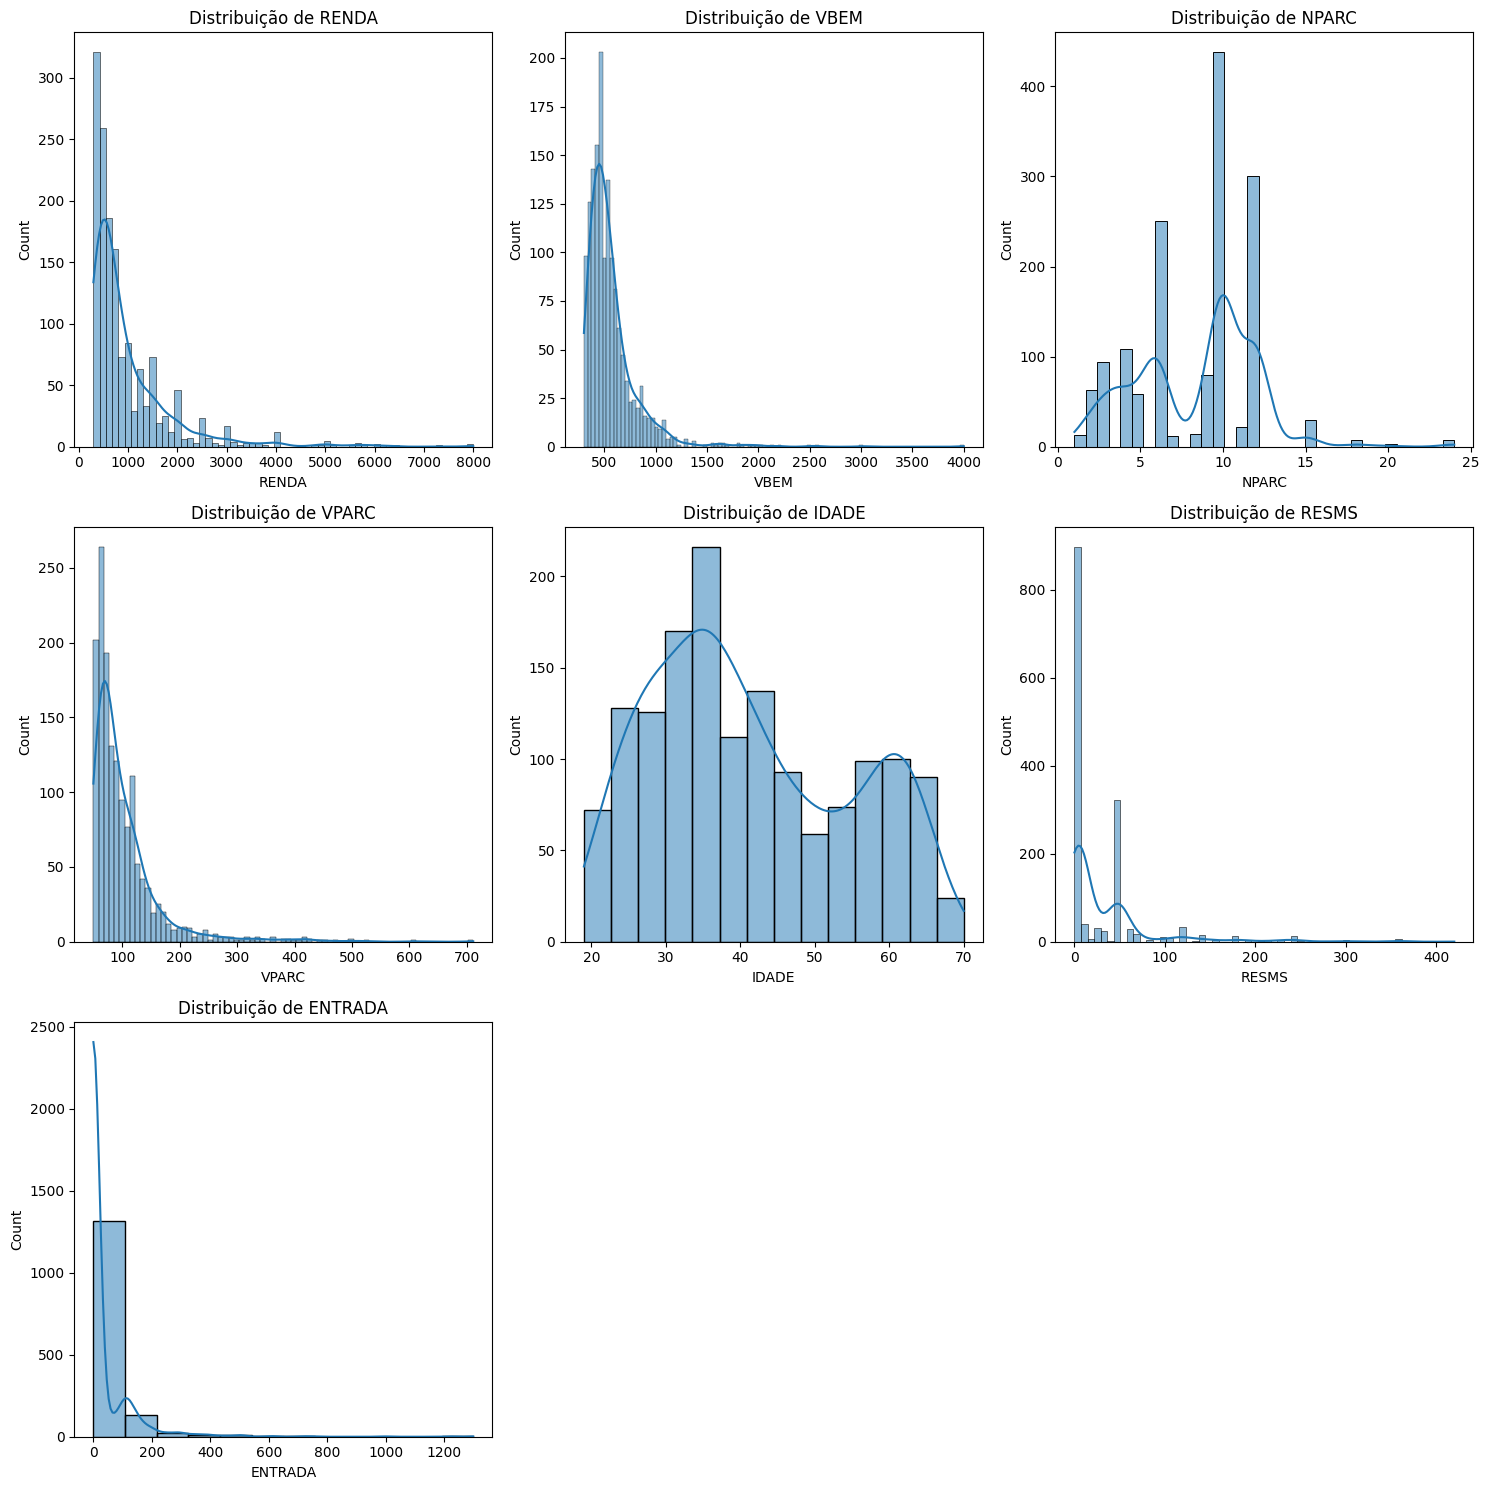

In [57]:
# Bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, classification_report


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error




# Definição do dicionário de dados
column_mapping = {
    0: "ESCT",    # Estado civil
    1: "NDEP",    # Número de dependentes
    2: "RENDA",   # Renda Familiar
    3: "TIPOR",   # Tipo de residência
    4: "VBEM",    # Valor do bem a ser adquirido
    5: "NPARC",   # Número de parcelas
    6: "VPARC",   # Valor da parcela
    7: "TEL",     # Se possui telefone
    8: "IDADE",   # Idade do cliente
    9: "RESMS",   # Tempo de moradia (meses)
    10: "ENTRADA", # Valor da entrada
    11: "CLASSE"  # Cliente pagou a dívida (1=sim)
}

# Leitura dos arquivos
train_path = "data/credtrain.txt"
test_path = "data/credtest.txt"

# Leitura com nomes das colunas
df_train = pd.read_csv(train_path, sep="\t", header=None).rename(columns=column_mapping)
df_test = pd.read_csv(test_path, sep="\t", header=None).rename(columns=column_mapping)

# Análise exploratória inicial
print("=== Análise dos Conjuntos de Dados ===")
print("\nInformações do conjunto de treinamento:")
print(df_train.info())

print("\nInformações do conjunto de teste:")
print(df_test.info())

# Verificação do balanceamento das classes
print("\n=== Distribuição das Classes ===")
print("\nConjunto de treinamento:")
print(df_train["CLASSE"].value_counts(normalize=True).round(3))
print("\nConjunto de teste:")
print(df_test["CLASSE"].value_counts(normalize=True).round(3))

# Análise das distribuições das variáveis numéricas
numerical_cols = ["RENDA", "VBEM", "NPARC", "VPARC", "IDADE", "RESMS", "ENTRADA"]

# Criar subplots para cada variável numérica
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

# Plotar distribuições
for idx, col in enumerate(numerical_cols):
    sns.histplot(data=df_train, x=col, ax=axes[idx], kde=True)
    axes[idx].set_title(f'Distribuição de {col}')
    axes[idx].set_xlabel(col)

# Remover subplot extra
axes[-1].remove()
axes[-2].remove()

plt.tight_layout()
plt.show()


### Pré-processamento das variáveis categóricas

In [58]:
# Definição das variáveis categóricas
categorical_features = ['ESCT', 'TIPOR', 'TEL', 'NDEP']

# Copia dos dataframes para não modificar os originais
y_train = df_train['CLASSE'].copy()
y_test = df_test['CLASSE'].copy()
X_train_prep = df_train.drop('CLASSE', axis=1).copy()
X_test_prep = df_test.drop('CLASSE', axis=1).copy()

# One-Hot Encoding para todas as variáveis categóricas
ohe = OneHotEncoder(sparse_output=False, drop='first')

# Fit e transform no conjunto de treino
categorical_encoded = ohe.fit_transform(X_train_prep[categorical_features])

# Criar nomes para as novas colunas
feature_names = []
for i, feature in enumerate(categorical_features):
    categories = ohe.categories_[i][1:]
    feature_names.extend([f"{feature}_{cat}" for cat in categories])

# Adicionar colunas encoded ao DataFrame de treino
encoded_df_train = pd.DataFrame(categorical_encoded, columns=feature_names, index=X_train_prep.index)
X_train_prep = pd.concat([X_train_prep.drop(columns=categorical_features), encoded_df_train], axis=1)

# Transform no conjunto de teste
categorical_encoded_test = ohe.transform(X_test_prep[categorical_features])
encoded_df_test = pd.DataFrame(categorical_encoded_test, columns=feature_names, index=X_test_prep.index)
X_test_prep = pd.concat([X_test_prep.drop(columns=categorical_features), encoded_df_test], axis=1)

# Verificação das transformações
print("\n=== Resultado do Preprocessamento ===")
print(f"\nNúmero de features após one-hot encoding: {X_train_prep.shape[1]}")
print("\nNovas variáveis categóricas:")
print([col for col in X_train_prep.columns if any(f in col for f in categorical_features)])

# Exibição dos primeiros registros do DataFrame transformado
print("\n=== Primeiros 10 registros após transformação ===")
print(X_train_prep.head(10))

# Guardar os nomes das colunas para uso posterior
column_names = X_train_prep.columns.tolist()


=== Resultado do Preprocessamento ===

Número de features após one-hot encoding: 19

Novas variáveis categóricas:
['ESCT_1', 'ESCT_2', 'ESCT_3', 'TIPOR_1', 'TEL_1', 'NDEP_1', 'NDEP_2', 'NDEP_3', 'NDEP_4', 'NDEP_5', 'NDEP_6', 'NDEP_7']

=== Primeiros 10 registros após transformação ===
   RENDA  VBEM  NPARC  VPARC  IDADE  RESMS  ENTRADA  ESCT_1  ESCT_2  ESCT_3  \
0    360   313      9     52     25     48        0     1.0     0.0     0.0   
1    350   468     10     65     33      6        0     0.0     0.0     0.0   
2   1100   829      9    125     56     48        0     0.0     0.0     0.0   
3   3000   552     12     76     31     60        0     0.0     0.0     0.0   
4   1000   809     12    111     24      7        0     1.0     0.0     0.0   
5    300   331      6     74     41      0        0     0.0     0.0     0.0   
6    580   349     10     51     30      6        0     0.0     0.0     0.0   
7    300   416     10     64     48    108        0     0.0     0.0     0.0   
8 

### Pré-processamento das variáveis numéricas

In [59]:
# Normalização das variáveis numéricas

# Definição das variáveis numéricas e seus respectivos scalers
numeric_features = {
    'standard': ['IDADE', 'NPARC'],  # Variáveis com distribuição aproximadamente normal
    'robust': ['RENDA', 'VBEM', 'VPARC', 'ENTRADA'],  # Variáveis com outliers
    'minmax': ['RESMS']  # Variável temporal com limite natural
}

# Copia dos dataframes já processados anteriormente
X_train_final = X_train_prep.copy()
X_test_final = X_test_prep.copy()

# Dicionário para armazenar os scalers
scalers = {}

# Aplicar StandardScaler
std_scaler = StandardScaler()
for col in numeric_features['standard']:
    scalers[col] = std_scaler
    X_train_final[col] = std_scaler.fit_transform(X_train_final[[col]])
    X_test_final[col] = std_scaler.transform(X_test_final[[col]])

# Aplicar RobustScaler
rob_scaler = RobustScaler()
for col in numeric_features['robust']:
    scalers[col] = rob_scaler
    X_train_final[col] = rob_scaler.fit_transform(X_train_final[[col]])
    X_test_final[col] = rob_scaler.transform(X_test_final[[col]])

# Aplicar MinMaxScaler
mm_scaler = MinMaxScaler()
for col in numeric_features['minmax']:
    scalers[col] = mm_scaler
    X_train_final[col] = mm_scaler.fit_transform(X_train_final[[col]])
    X_test_final[col] = mm_scaler.transform(X_test_final[[col]])

# Verificação dos intervalos de valores antes/depois da normalização
all_features = (numeric_features['standard'] + 
                numeric_features['robust'] + 
                numeric_features['minmax'])

print("\n=== Intervalos de valores antes/depois da normalização ===")
for feature in all_features:
    print(f"\nFeature: {feature}")
    print(f"Original     - min: {df_train[feature].min():10.2f}, max: {df_train[feature].max():10.2f}")
    print(f"Normalizado - min: {X_train_final[feature].min():10.2f}, max: {X_train_final[feature].max():10.2f}")
    print(f"Scaler usado: {scalers[feature].__class__.__name__}")


=== Intervalos de valores antes/depois da normalização ===

Feature: IDADE
Original     - min:      19.00, max:      70.00
Normalizado - min:      -1.68, max:       2.18
Scaler usado: StandardScaler

Feature: NPARC
Original     - min:       1.00, max:      24.00
Normalizado - min:      -2.05, max:       4.33
Scaler usado: StandardScaler

Feature: RENDA
Original     - min:     300.00, max:    8000.00
Normalizado - min:      -0.48, max:      10.03
Scaler usado: RobustScaler

Feature: VBEM
Original     - min:     300.00, max:    4000.00
Normalizado - min:      -0.91, max:      16.88
Scaler usado: RobustScaler

Feature: VPARC
Original     - min:      50.00, max:     711.00
Normalizado - min:      -0.63, max:      12.08
Scaler usado: RobustScaler

Feature: ENTRADA
Original     - min:       0.00, max:    1300.00
Normalizado - min:       0.00, max:    1300.00
Scaler usado: RobustScaler

Feature: RESMS
Original     - min:       0.00, max:     420.00
Normalizado - min:       0.00, max:       1

### Processamento e resultados com os modelos propostos

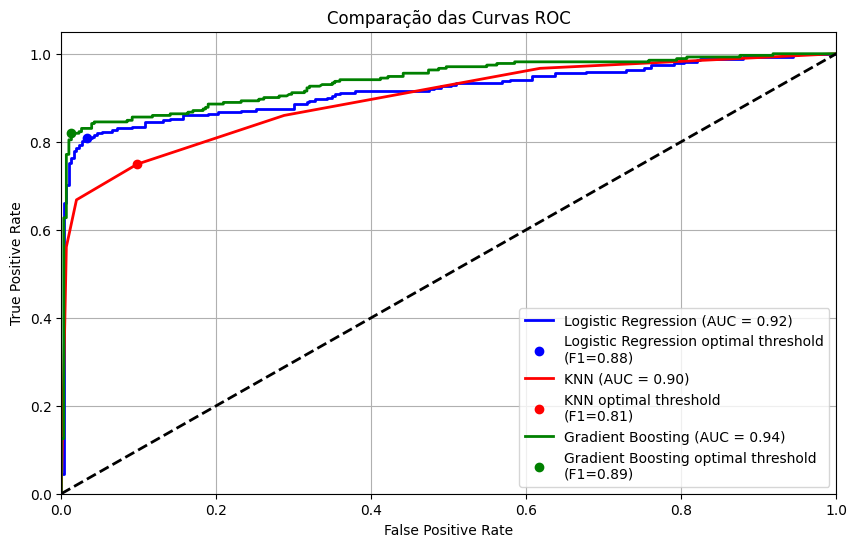

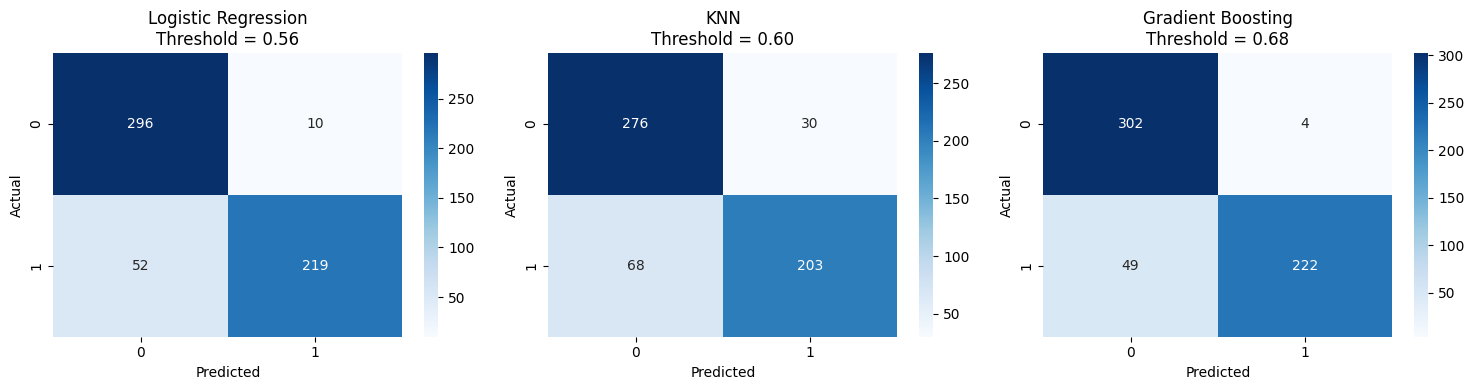


=== Classification Reports ===

Logistic Regression:
Threshold: 0.562
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       306
           1       0.96      0.81      0.88       271

    accuracy                           0.89       577
   macro avg       0.90      0.89      0.89       577
weighted avg       0.90      0.89      0.89       577


KNN:
Threshold: 0.600
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       306
           1       0.87      0.75      0.81       271

    accuracy                           0.83       577
   macro avg       0.84      0.83      0.83       577
weighted avg       0.83      0.83      0.83       577


Gradient Boosting:
Threshold: 0.676
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       306
           1       0.98      0.82      0.89       271

    accuracy                           0.91       5

In [60]:
# Inicialização dos modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Dicionários para armazenar resultados
results = {}

# Criar figura única para todas as curvas ROC
plt.figure(figsize=(10, 6))

# Cores para cada modelo
colors = ['blue', 'red', 'green']

for (name, model), color in zip(models.items(), colors):
    # Treinar modelo
    model.fit(X_train_final, y_train)
    
    # Obter probabilidades de predição
    y_prob = model.predict_proba(X_test_final)[:, 1]
    
    # Calcular curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Calcular F1-scores para diferentes limiares
    f1_scores = []
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        f1 = f1_score(y_test, y_pred)
        f1_scores.append(f1)
    
    # Encontrar limiar ótimo
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    # Plotar curva ROC
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{name} (AUC = {roc_auc:.2f})')
    
    # Marcar ponto do limiar ótimo
    plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'o', color=color,
             label=f'{name} optimal threshold\n(F1={f1_scores[optimal_idx]:.2f})')
    
    # Calcular predições com limiar ótimo
    y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
    
    # Armazenar resultados
    results[name] = {
        'threshold': optimal_threshold,
        'predictions': y_pred_optimal,
        'confusion_matrix': confusion_matrix(y_test, y_pred_optimal),
        'classification_report': classification_report(y_test, y_pred_optimal)
    }

# Finalizar gráfico ROC
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparação das Curvas ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plotar matrizes de confusão
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, (name, result) in enumerate(results.items()):
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name}\nThreshold = {result["threshold"]:.2f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Exibir classification reports
print("\n=== Classification Reports ===")
for name, result in results.items():
    print(f"\n{name}:")
    print(f"Threshold: {result['threshold']:.3f}")
    print(result['classification_report'])

# (2) Predição de preços de diamantes

### Análise exploratória da base fornecida

=== Informações gerais do dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB
None
=== Dimensões dos conjuntos ===
X_train: (43152, 9)
X_test: (10788, 9)
y_train: (43152,)
y_test: (10788,)

=== Estatísticas da variável target ===

Conjunto de treino:
count    43152.000000
mean      3939.490707
std       3990.000962
min        326.0000

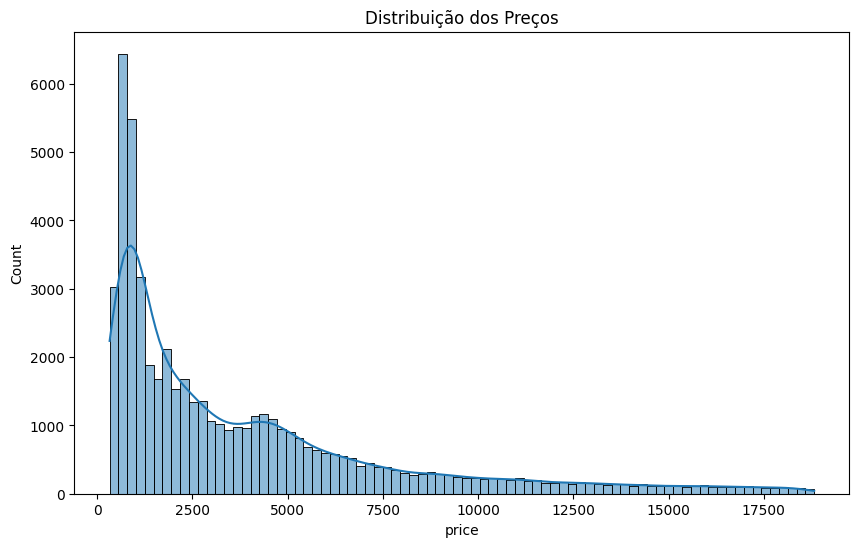

In [61]:
# Carregando o dataset diamonds
df = pd.read_csv('data/diamonds.csv')

# Análise inicial dos dados
print("=== Informações gerais do dataset ===")
print(df.info())

# Remove a coluna Unnamed: 0 e separa features de target
df = df.drop('Unnamed: 0', axis=1)
X = df.drop('price', axis=1)
y = df['price']

# Divisão em conjuntos de treino e teste (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Verificação dos conjuntos
print("=== Dimensões dos conjuntos ===")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Verificação da distribuição da variável target
print("\n=== Estatísticas da variável target ===")
print("\nConjunto de treino:")
print(y_train.describe())
print("\nConjunto de teste:")
print(y_test.describe())

# Distribuição da variável target (price)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='price', kde=True)
plt.title('Distribuição dos Preços')
plt.show()

### Análise das variáveis categóricas

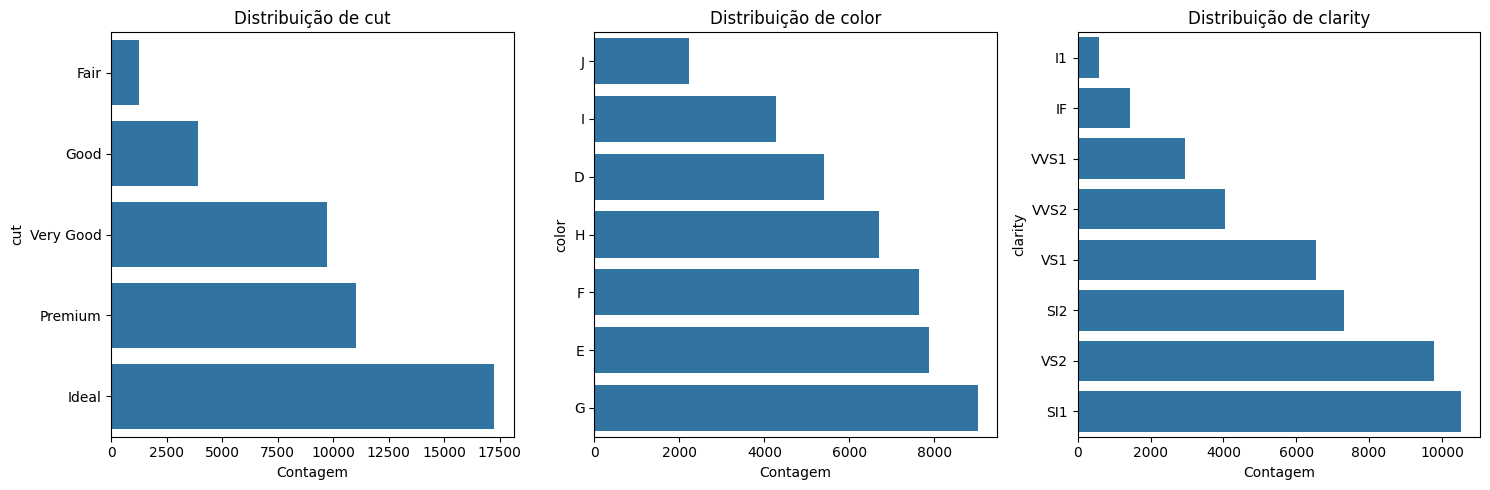


=== Cardinalidade das variáveis categóricas ===
cut: 5 valores únicos
Valores: ['Fair', 'Good', 'Ideal', 'Premium', 'Very Good']
color: 7 valores únicos
Valores: ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity: 8 valores únicos
Valores: ['I1', 'IF', 'SI1', 'SI2', 'VS1', 'VS2', 'VVS1', 'VVS2']


In [62]:
# Análise das variáveis categóricas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definição das variáveis categóricas
categorical_features = ['cut', 'color', 'clarity']

# Criar subplots para visualizar a distribuição de cada variável categórica
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, feature in enumerate(categorical_features):
    # Calcular contagens e ordenar por frequência
    value_counts = X_train[feature].value_counts().sort_values(ascending=True)
    
    # Plotar barras horizontais
    sns.barplot(x=value_counts.values, y=value_counts.index, ax=axes[idx])
    axes[idx].set_title(f'Distribuição de {feature}')
    axes[idx].set_xlabel('Contagem')
    
plt.tight_layout()
plt.show()

# Exibir cardinalidade de cada variável
print("\n=== Cardinalidade das variáveis categóricas ===")
for feature in categorical_features:
    n_unique = X_train[feature].nunique()
    print(f"{feature}: {n_unique} valores únicos")
    print("Valores:", sorted(X_train[feature].unique()))

### Verificação da ordenação das categorias

In [63]:
# Análise das variáveis categóricas ordinais e verificação da ordem
categorical_features = {
    'cut': ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],  # Qualidade do corte
    'color': ['J', 'I', 'H', 'G', 'F', 'E', 'D'],  # D é a melhor (incolor)
    'clarity': ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']  # IF é a melhor
}

# Verificar ordenação das categorias
print("\n=== Verificação da ordenação das categorias ===")
print("Nota: A ordem das categorias nos dados não segue a ordem natural do domínio.")
print("Isso reforça a necessidade de usar OneHotEncoder em vez de codificação ordinal.")

for feature, ordered_categories in categorical_features.items():
    actual_categories = sorted(X_train[feature].unique())
    print(f"\nVerificando ordem de {feature}:")
    print(f"Ordem natural: {ordered_categories}")
    print(f"Ordem nos dados: {actual_categories}")


=== Verificação da ordenação das categorias ===
Nota: A ordem das categorias nos dados não segue a ordem natural do domínio.
Isso reforça a necessidade de usar OneHotEncoder em vez de codificação ordinal.

Verificando ordem de cut:
Ordem natural: ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
Ordem nos dados: ['Fair', 'Good', 'Ideal', 'Premium', 'Very Good']

Verificando ordem de color:
Ordem natural: ['J', 'I', 'H', 'G', 'F', 'E', 'D']
Ordem nos dados: ['D', 'E', 'F', 'G', 'H', 'I', 'J']

Verificando ordem de clarity:
Ordem natural: ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
Ordem nos dados: ['I1', 'IF', 'SI1', 'SI2', 'VS1', 'VS2', 'VVS1', 'VVS2']


### Aplicação do One-Hot-Encoding

In [64]:
# Definição das variáveis categóricas
categorical_features = ['cut', 'color', 'clarity']

# One-Hot Encoding para variáveis categóricas
ohe = OneHotEncoder(sparse_output=False, drop='first')

# Fit e transform no conjunto de treino
categorical_encoded = ohe.fit_transform(X_train[categorical_features])

# Criar nomes para as novas colunas
feature_names = []
for i, feature in enumerate(categorical_features):
    categories = ohe.categories_[i][1:]  # Excluindo a primeira categoria (drop='first')
    feature_names.extend([f"{feature}_{cat}" for cat in categories])

# Adicionar colunas encoded ao DataFrame de treino
encoded_df_train = pd.DataFrame(categorical_encoded, columns=feature_names, index=X_train.index)
X_train_encoded = pd.concat([X_train.drop(columns=categorical_features), encoded_df_train], axis=1)

# Transform no conjunto de teste
categorical_encoded_test = ohe.transform(X_test[categorical_features])
encoded_df_test = pd.DataFrame(categorical_encoded_test, columns=feature_names, index=X_test.index)
X_test_encoded = pd.concat([X_test.drop(columns=categorical_features), encoded_df_test], axis=1)

# Verificação das transformações
print("=== Resultado do Preprocessamento ===")
print(f"\nNúmero de features após one-hot encoding: {X_train_encoded.shape[1]}")
print("\nNovas variáveis categóricas:")
print([col for col in X_train_encoded.columns if any(f in col for f in categorical_features)])

# Exibição dos primeiros registros do DataFrame transformado
print("\n=== Primeiros 5 registros após transformação ===")
print("\nVariáveis numéricas e dummies:")
print(X_train_encoded.head())

# Exibir algumas estatísticas das novas features
print("\n=== Resumo das novas features categóricas ===")
dummy_cols = [col for col in X_train_encoded.columns if any(f in col for f in categorical_features)]
print(X_train_encoded[dummy_cols].describe().round(3))

=== Resultado do Preprocessamento ===

Número de features após one-hot encoding: 23

Novas variáveis categóricas:
['cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']

=== Primeiros 5 registros após transformação ===

Variáveis numéricas e dummies:
       carat  depth  table     x     y     z  cut_Good  cut_Ideal  \
26546   2.01   58.1   64.0  8.23  8.19  4.77       1.0        0.0   
9159    1.01   60.0   60.0  6.57  6.49  3.92       0.0        0.0   
14131   1.10   62.5   58.0  6.59  6.54  4.10       0.0        0.0   
15757   1.50   61.5   65.0  7.21  7.17  4.42       1.0        0.0   
24632   1.52   62.1   57.0  7.27  7.32  4.53       0.0        0.0   

       cut_Premium  cut_Very Good  ...  color_H  color_I  color_J  clarity_IF  \
26546          0.0            0.0  ...      0.0      0.0      0.0         0.0 

### Pré-processamento das variáveis numéricas

In [65]:
# Normalização das variáveis numéricas

# Definição das variáveis numéricas e seus respectivos scalers
numeric_features = {
    'standard': ['depth', 'table'],  # Variáveis com distribuição aproximadamente normal
    'robust': ['carat'],            # Variáveis com outliers
    'minmax': ['x', 'y', 'z']      # Variáveis de dimensão com limites naturais
}

# Copia dos dataframes já processados anteriormente
X_train_final = X_train_encoded.copy()
X_test_final = X_test_encoded.copy()

# Dicionário para armazenar os scalers
scalers = {}

# Aplicar StandardScaler para variáveis com distribuição normal
std_scaler = StandardScaler()
for col in numeric_features['standard']:
    scalers[col] = std_scaler
    X_train_final[col] = std_scaler.fit_transform(X_train_final[[col]])
    X_test_final[col] = std_scaler.transform(X_test_final[[col]])

# Aplicar RobustScaler para variáveis com outliers
rob_scaler = RobustScaler()
for col in numeric_features['robust']:
    scalers[col] = rob_scaler
    X_train_final[col] = rob_scaler.fit_transform(X_train_final[[col]])
    X_test_final[col] = rob_scaler.transform(X_test_final[[col]])

# Aplicar MinMaxScaler para variáveis com limites naturais
mm_scaler = MinMaxScaler()
for col in numeric_features['minmax']:
    scalers[col] = mm_scaler
    X_train_final[col] = mm_scaler.fit_transform(X_train_final[[col]])
    X_test_final[col] = mm_scaler.transform(X_test_final[[col]])

# Verificação dos intervalos antes/depois
print("\n=== Intervalos de valores antes/depois da normalização ===")
for feature in sum(numeric_features.values(), []):
    print(f"\nFeature: {feature}")
    print(f"Original     - min: {X_train[feature].min():10.2f}, max: {X_train[feature].max():10.2f}")
    print(f"Normalizado - min: {X_train_final[feature].min():10.2f}, max: {X_train_final[feature].max():10.2f}")
    print(f"Scaler usado: {scalers[feature].__class__.__name__}")


=== Intervalos de valores antes/depois da normalização ===

Feature: depth
Original     - min:      43.00, max:      79.00
Normalizado - min:     -13.12, max:      12.08
Scaler usado: StandardScaler

Feature: table
Original     - min:      43.00, max:      95.00
Normalizado - min:      -6.49, max:      16.84
Scaler usado: StandardScaler

Feature: carat
Original     - min:       0.20, max:       5.01
Normalizado - min:      -0.78, max:       6.73
Scaler usado: RobustScaler

Feature: x
Original     - min:       0.00, max:      10.74
Normalizado - min:       0.00, max:       1.00
Scaler usado: MinMaxScaler

Feature: y
Original     - min:       0.00, max:      58.90
Normalizado - min:       0.00, max:       1.00
Scaler usado: MinMaxScaler

Feature: z
Original     - min:       0.00, max:      31.80
Normalizado - min:       0.00, max:       1.00
Scaler usado: MinMaxScaler


### Processamento aplicando os algoritmos propostos com avaliação dos resultados


Treinando Linear Regression...
Resultados para Linear Regression:
RMSE: 1135.21
R²: 0.9189

Treinando KNN...
Resultados para KNN:
RMSE: 1066.84
R²: 0.9284

Treinando Gradient Boosting...
Resultados para Gradient Boosting:
RMSE: 846.11
R²: 0.9550


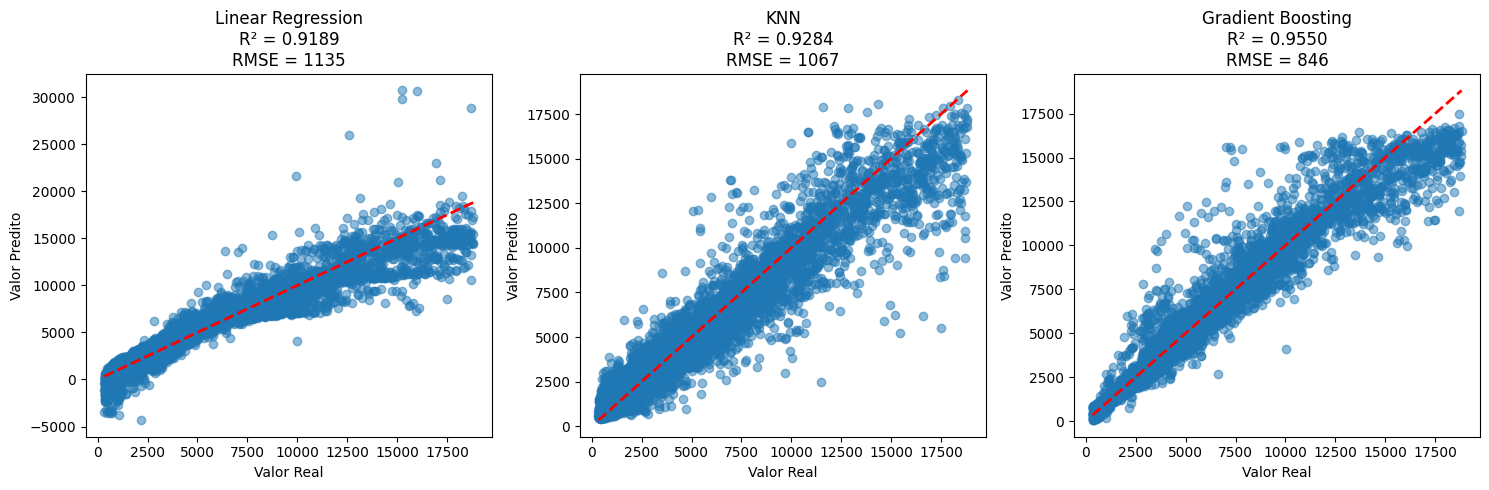

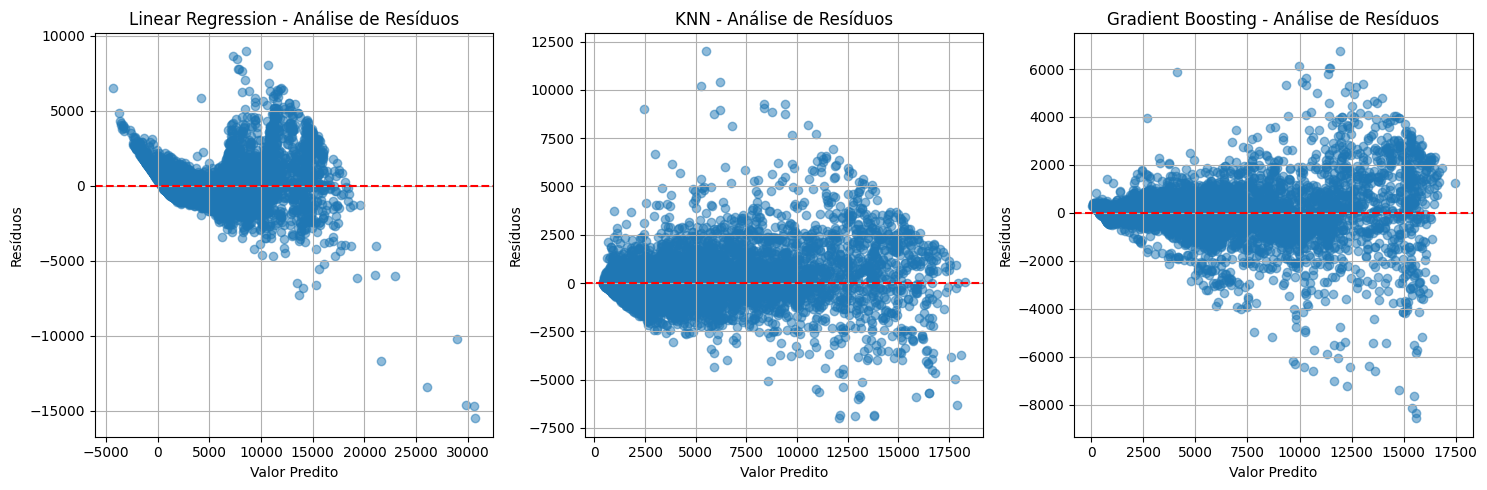

In [66]:


# Inicializa os modelos
models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Treina e avalia os modelos
results = {}

for name, model in models.items():
    # Treina o modelo
    print(f"\nTreinando {name}...")
    model.fit(X_train_final, y_train)
    
    # Faz previsões
    y_pred = model.predict(X_test_final)
    
    # Calcula métricas
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Armazena resultados
    results[name] = {
        'R2': r2,
        'RMSE': rmse
    }
    
    print(f"Resultados para {name}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")

# Plotagem dos resultados (Actual vs Predicted)
plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    y_pred = model.predict(X_test_final)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Valor Real')
    plt.ylabel('Valor Predito')
    plt.title(f'{name}\nR² = {results[name]["R2"]:.4f}\nRMSE = {results[name]["RMSE"]:.0f}')

plt.tight_layout()
plt.show()

# Plotagem dos resíduos
plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    y_pred = model.predict(X_test_final)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Valor Predito')
    plt.ylabel('Resíduos')
    plt.title(f'{name} - Análise de Resíduos')
    plt.grid(True)

plt.tight_layout()
plt.show()



# (3) Conjuntos desbalanceados - parte I

### Instruções iniciais 

In [67]:
# Intruções Iniciais
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier



f = open('data/A652.pickle', 'rb')

(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(f)
print (f"Shapes: ", X_train.shape, X_val.shape, X_test.shape)

f.close()



Shapes:  (10012, 24) (2506, 24) (9582, 24)


### Carregando a base em Pandas para maior flexibilidade   

In [68]:
# Verificação dos tamanhos dos conjuntos
print("=== Tamanho dos Conjuntos de Dados originais (A652.pickle) ===")
print(f"X_train: {X_train.shape} amostras, {X_train.shape[1]} features")
print(f"X_val:   {X_val.shape} amostras, {X_val.shape[1]} features")
print(f"X_test:  {X_test.shape} amostras, {X_test.shape[1]} features")


# Transforma em dataframe
X_train = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
X_val = pd.DataFrame(X_val, columns=[f'feature_{i}' for i in range(X_val.shape[1])])
X_test = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])


print("Train class distribution:")
print(pd.Series(y_train.ravel()).value_counts(normalize=True))
print("\nValidation class distribution:")
print(pd.Series(y_val.ravel()).value_counts(normalize=True))
print("\nTest class distribution:")
print(pd.Series(y_test.ravel()).value_counts(normalize=True))

=== Tamanho dos Conjuntos de Dados originais (A652.pickle) ===
X_train: (10012, 24) amostras, 24 features
X_val:   (2506, 24) amostras, 24 features
X_test:  (9582, 24) amostras, 24 features
Train class distribution:
0.0     0.924690
0.2     0.018977
0.4     0.008789
0.6     0.007491
0.8     0.005493
          ...   
30.0    0.000100
32.6    0.000100
16.0    0.000100
18.2    0.000100
12.4    0.000100
Name: proportion, Length: 74, dtype: float64

Validation class distribution:
0.0     0.908619
0.2     0.019154
0.4     0.015962
0.6     0.011173
1.0     0.006385
0.8     0.005986
1.6     0.005188
1.4     0.004789
1.2     0.003990
4.0     0.001995
1.8     0.001995
2.0     0.001596
2.6     0.001596
2.2     0.001596
3.6     0.001197
3.4     0.000798
2.4     0.000798
7.4     0.000798
3.2     0.000798
4.8     0.000798
3.0     0.000798
7.6     0.000399
29.4    0.000399
5.2     0.000399
4.2     0.000399
3.8     0.000399
4.4     0.000399
4.6     0.000399
2.8     0.000399
8.2     0.000399
6.6     0.

### Transformação para um problema de classificação com análise de balanceamento

=== Distribuição das Classes ===

Conjunto de Treinamento:
0    0.92469
1    0.07531
Name: proportion, dtype: float64

Conjunto de Validação:
0    0.908619
1    0.091381
Name: proportion, dtype: float64

Conjunto de Teste:
0    0.915153
1    0.084847
Name: proportion, dtype: float64


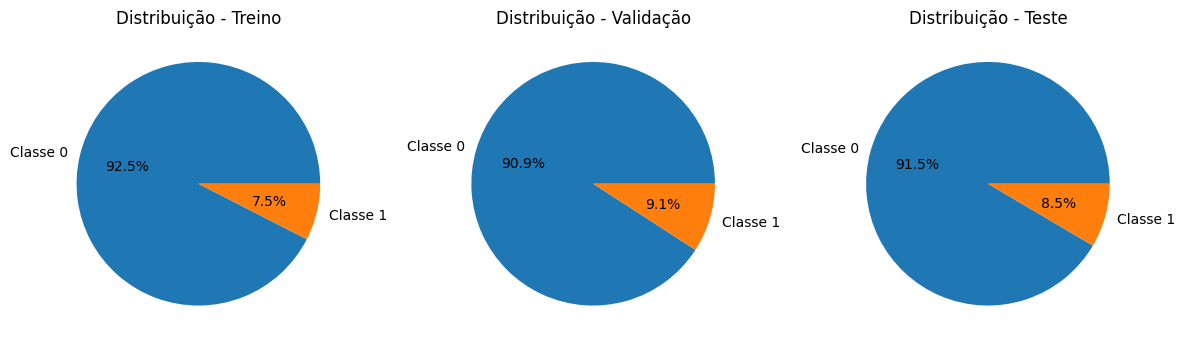

In [69]:
# Criando rótulos binários
y_train_binary = (y_train != 0).astype(int)
y_val_binary = (y_val != 0).astype(int)
y_test_binary = (y_test != 0).astype(int)

# Verificando a distribuição das classes
print("=== Distribuição das Classes ===")
print("\nConjunto de Treinamento:")
print(pd.Series(y_train_binary.ravel()).value_counts(normalize=True))
print("\nConjunto de Validação:")
print(pd.Series(y_val_binary.ravel()).value_counts(normalize=True))
print("\nConjunto de Teste:")
print(pd.Series(y_test_binary.ravel()).value_counts(normalize=True))

# Plotando a distribuição das classes
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.pie(pd.Series(y_train_binary.ravel()).value_counts(), 
    labels=['Classe 0', 'Classe 1'],
    autopct='%1.1f%%')
plt.title('Distribuição - Treino')

plt.subplot(132)
plt.pie(pd.Series(y_val_binary.ravel()).value_counts(), 
    labels=['Classe 0', 'Classe 1'],
    autopct='%1.1f%%')
plt.title('Distribuição - Validação')

plt.subplot(133)
plt.pie(pd.Series(y_test_binary.ravel()).value_counts(), 
    labels=['Classe 0', 'Classe 1'],
    autopct='%1.1f%%')
plt.title('Distribuição - Teste')

plt.tight_layout()
plt.show()

### Aplicação do Gradient Boosting e comparação dos resultados entre o modelo base e os modelos com undersamplin, oversampling e ajuste de limiar

<Figure size 1200x600 with 0 Axes>

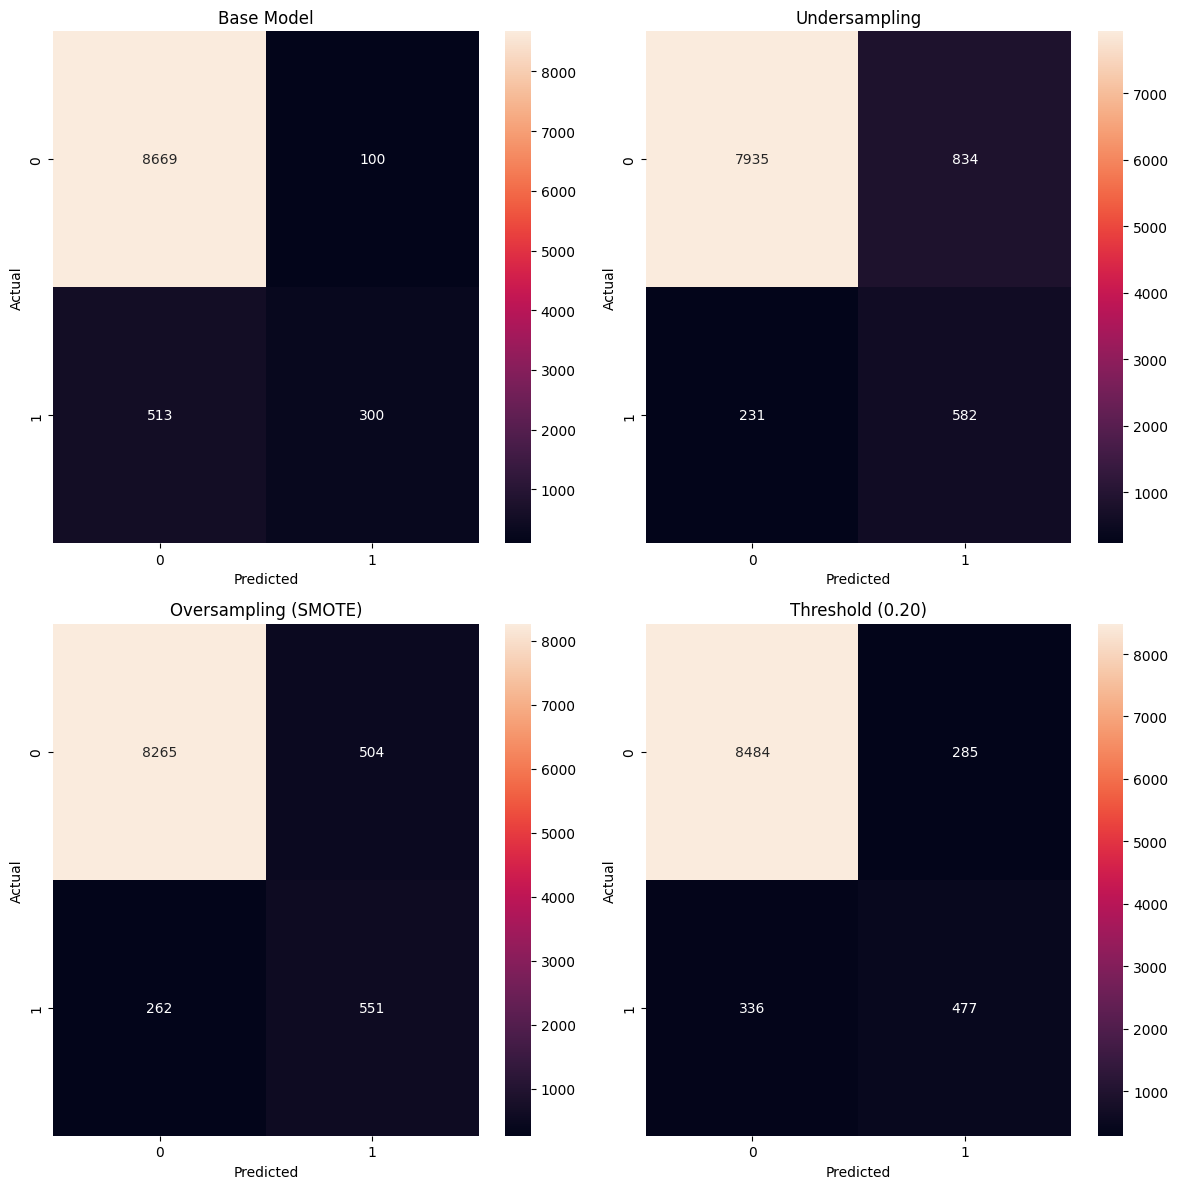


Comparação dos resultados encontrados:
               Model  Accuracy  Precision (Class 1)  Recall (Class 1)  F1-score (Class 1)
          Base Model  0.936026             0.750000          0.369004            0.494641
       Undersampling  0.888854             0.411017          0.715867            0.522207
Oversampling (SMOTE)  0.920058             0.522275          0.677737            0.589936
           Threshold  0.935191             0.625984          0.586716            0.605714


In [70]:
# Treinamento do modelo base (sem balanceamento)
base_model = GradientBoostingClassifier(random_state=42)
base_model.fit(X_train, y_train_binary.ravel())

# Predições
base_pred = base_model.predict(X_test)


# Undersampling - Reduzindo a classe majoritária
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train_binary.ravel())

# Treinamento do  modelo com undersampling
under_model = GradientBoostingClassifier(random_state=42)
under_model.fit(X_train_under, y_train_under)

# Predições
under_pred = under_model.predict(X_test)


# Oversampling - Aumentando a classe minoritária
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train_binary.ravel())

# Treinamento do modelo com oversampling
over_model = GradientBoostingClassifier(random_state=42)
over_model.fit(X_train_over, y_train_over)

# Predições
over_pred = over_model.predict(X_test)


# Alteração de limiar - usando probabilidades do modelo base
# Encontrar melhor limiar usando F1-score
thresholds = np.arange(0.1, 0.9, 0.1)
f1_scores = []

# Usar conjunto de validação para ajustar o limiar
val_probs = base_model.predict_proba(X_val)[:, 1]

for threshold in thresholds:
    val_pred = (val_probs >= threshold).astype(int)
    f1 = f1_score(y_val_binary, val_pred)
    f1_scores.append(f1)

# Encontrar melhor limiar com base no conjunto de validação
best_threshold = thresholds[np.argmax(f1_scores)]


# Aplicar o limiar otimizado no conjunto de teste
test_probs = base_model.predict_proba(X_test)[:, 1]
threshold_pred = (test_probs >= best_threshold).astype(int)



# Plotar matrizes de confusão
plt.figure(figsize=(12, 6))
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
titles = ['Base Model', 'Undersampling', 'Oversampling (SMOTE)', f'Threshold ({best_threshold:.2f})']
predictions = [base_pred, under_pred, over_pred, threshold_pred]

for ax, title, pred in zip(axes.ravel(), titles, predictions):
    sns.heatmap(confusion_matrix(y_test_binary, pred), annot=True, fmt='d', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Criação da tabela de comparação
metrics = {
    'Model': ['Base Model', 'Undersampling', 'Oversampling (SMOTE)', 'Threshold'],
    'Accuracy': [],
    'Precision (Class 1)': [], 
    'Recall (Class 1)': [],
    'F1-score (Class 1)': []
}

# Base model metrics
base_report = classification_report(y_test_binary, base_pred, output_dict=True)
metrics['Accuracy'].append(base_report['accuracy'])
metrics['Precision (Class 1)'].append(base_report['1']['precision'])
metrics['Recall (Class 1)'].append(base_report['1']['recall'])
metrics['F1-score (Class 1)'].append(base_report['1']['f1-score'])

# Undersampling metrics
under_report = classification_report(y_test_binary, under_pred, output_dict=True)
metrics['Accuracy'].append(under_report['accuracy'])
metrics['Precision (Class 1)'].append(under_report['1']['precision'])
metrics['Recall (Class 1)'].append(under_report['1']['recall'])
metrics['F1-score (Class 1)'].append(under_report['1']['f1-score'])

# Oversampling metrics
over_report = classification_report(y_test_binary, over_pred, output_dict=True)
metrics['Accuracy'].append(over_report['accuracy'])
metrics['Precision (Class 1)'].append(over_report['1']['precision'])
metrics['Recall (Class 1)'].append(over_report['1']['recall'])
metrics['F1-score (Class 1)'].append(over_report['1']['f1-score'])

# Threshold metrics
thresh_report = classification_report(y_test_binary, threshold_pred, output_dict=True)
metrics['Accuracy'].append(thresh_report['accuracy'])
metrics['Precision (Class 1)'].append(thresh_report['1']['precision'])
metrics['Recall (Class 1)'].append(thresh_report['1']['recall'])
metrics['F1-score (Class 1)'].append(thresh_report['1']['f1-score'])

# Criação do DataFrame para exibição
comparison_df = pd.DataFrame(metrics)
print("\nComparação dos resultados encontrados:")
print(comparison_df.to_string(index=False))

# (4) Conjuntos desbalanceados - parte II

### Inspecionando as bases e distribuições originais

In [71]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier

# Verificação dos tamanhos dos conjuntos
print("=== Tamanho dos Conjuntos de Dados originais (A652.pickle) ===")
print(f"X_train: {X_train.shape} amostras, {X_train.shape[1]} features")
print(f"X_val:   {X_val.shape} amostras, {X_val.shape[1]} features")
print(f"X_test:  {X_test.shape} amostras, {X_test.shape[1]} features")

print("Train class distribution:")
print(pd.Series(y_train.ravel()).value_counts(normalize=True))
print("\nValidation class distribution:")
print(pd.Series(y_val.ravel()).value_counts(normalize=True))
print("\nTest class distribution:")
print(pd.Series(y_test.ravel()).value_counts(normalize=True))



=== Tamanho dos Conjuntos de Dados originais (A652.pickle) ===
X_train: (10012, 24) amostras, 24 features
X_val:   (2506, 24) amostras, 24 features
X_test:  (9582, 24) amostras, 24 features
Train class distribution:
0.0     0.924690
0.2     0.018977
0.4     0.008789
0.6     0.007491
0.8     0.005493
          ...   
30.0    0.000100
32.6    0.000100
16.0    0.000100
18.2    0.000100
12.4    0.000100
Name: proportion, Length: 74, dtype: float64

Validation class distribution:
0.0     0.908619
0.2     0.019154
0.4     0.015962
0.6     0.011173
1.0     0.006385
0.8     0.005986
1.6     0.005188
1.4     0.004789
1.2     0.003990
4.0     0.001995
1.8     0.001995
2.0     0.001596
2.6     0.001596
2.2     0.001596
3.6     0.001197
3.4     0.000798
2.4     0.000798
7.4     0.000798
3.2     0.000798
4.8     0.000798
3.0     0.000798
7.6     0.000399
29.4    0.000399
5.2     0.000399
4.2     0.000399
3.8     0.000399
4.4     0.000399
4.6     0.000399
2.8     0.000399
8.2     0.000399
6.6     0.

### Criando versões binárias das matrizes alvo

In [72]:
# Criando rótulos binários
y_train_bin = (y_train != 0).astype(int)
y_val_bin = (y_val != 0).astype(int)
y_test_bin = (y_test != 0).astype(int)

# Verificando a distribuição das classes
print("=== Distribuição das Classes ===")
print("\nConjunto de Treinamento:")
print(pd.Series(y_train_binary.ravel()).value_counts(normalize=True))
print("\nConjunto de Validação:")
print(pd.Series(y_val_binary.ravel()).value_counts(normalize=True))
print("\nConjunto de Teste:")
print(pd.Series(y_test_binary.ravel()).value_counts(normalize=True))

=== Distribuição das Classes ===

Conjunto de Treinamento:
0    0.92469
1    0.07531
Name: proportion, dtype: float64

Conjunto de Validação:
0    0.908619
1    0.091381
Name: proportion, dtype: float64

Conjunto de Teste:
0    0.915153
1    0.084847
Name: proportion, dtype: float64


### Treinando o modelo C usando o Gradient Boosting

In [73]:
# 1. Treinar modelo C usando conjunto de treinamento
C = GradientBoostingClassifier(random_state=42)
C.fit(X_train, y_train_bin.ravel())

# 2. Aplicar C ao conjunto de validação
val_probs = C.predict_proba(X_val)[:, 1]  # Probabilidades da classe positiva
val_pred = C.predict(X_val)  # Predições usando threshold padrão (0.5)

# Exibir resultados iniciais no conjunto de validação
print("=== Resultados no conjunto de validação ===")
print("\nMatriz de confusão:")
print(confusion_matrix(y_val_bin, val_pred))
print("\nRelatório de classificação:")
print(classification_report(y_val_bin, val_pred))



=== Resultados no conjunto de validação ===

Matriz de confusão:
[[2244   33]
 [ 136   93]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2277
           1       0.74      0.41      0.52       229

    accuracy                           0.93      2506
   macro avg       0.84      0.70      0.74      2506
weighted avg       0.92      0.93      0.92      2506



### Criando os subconjuntos para o grupo classificado por C como classe 1

In [74]:
# Obter as predições do modelo C para X_train
train_pred = C.predict(X_train)

# Criar máscara booleana para selecionar exemplos classificados como classe 1
mask_classe_1 = (train_pred == 1)

# Definir X_train_1 e y_train_1 usando a máscara
X_train_1 = X_train[mask_classe_1]
y_train_1 = y_train_bin[mask_classe_1]

# Exibir informações sobre os subconjuntos
print("=== Tamanho dos subconjuntos ===")
print(f"X_train original: {X_train.shape}")
print(f"X_train_1: {X_train_1.shape}")
print(f"y_train_1: {y_train_1.shape}")
print("\nDistribuição das classes em y_train_1:")
print(pd.Series(y_train_1.ravel()).value_counts(normalize=True))

=== Tamanho dos subconjuntos ===
X_train original: (10012, 24)
X_train_1: (568, 24)
y_train_1: (568, 1)

Distribuição das classes em y_train_1:
1    0.818662
0    0.181338
Name: proportion, dtype: float64


### Treinando o modelo R para a regressão dos subconjuntos

In [75]:
# Treinamento do modelo de regressão R usando X_train_1 
R = GradientBoostingRegressor(random_state=42)
R.fit(X_train_1, y_train_1.ravel())

# Verificação básica do modelo
print("=== Modelo de Regressão R ===")
print(f"Treinado com {X_train_1.shape[0]} amostras")
print(f"Número de features: {X_train_1.shape[1]}")
#print("\nDistribuição dos valores alvo em y_train_1:")
#print(pd.Series(y_train_1.ravel()).info())

=== Modelo de Regressão R ===
Treinado com 568 amostras
Número de features: 24


### Computando C(x)

In [76]:
# Aplicar o classificador no conjunto de teste
y_test_pred_class = C.predict(X_test).ravel()
print("\n=== Computando inicialmente C(x)  ===")
print(pd.Series(y_test_pred_class).value_counts(normalize=False))

# Prever valores de precipitação usando o modelo combinado
y_test_pred_final = np.where(
    y_test_pred_class == 0,
    0,
    R.predict(X_test).ravel()
)




=== Computando inicialmente C(x)  ===
0    9182
1     400
Name: count, dtype: int64


### Obtendo R' (y_test_pred_final)

In [77]:
# Criar máscara para valores positivos (onde C(x) = 1)
positive_mask = (y_test_pred_class == 1)

# Inicializar array final com zeros
y_test_pred_final = np.zeros_like(y_test.ravel())

# Aplicar modelo R apenas onde C(x) = 1
if np.sum(positive_mask) > 0:
    y_test_pred_final[positive_mask] = R.predict(X_test[positive_mask]).ravel()

# Análise dos resultados
print("\n=== Distribuição das Predições ===")
print(f"Total de amostras: {len(y_test_pred_class)}")
print(f"Amostras com C(x) = 0: {np.sum(y_test_pred_class == 0)}")
print(f"Amostras com C(x) = 1: {np.sum(y_test_pred_class == 1)}")



# 4.4 Avaliação do desempenho por nível de severidade
def classificar_severidade(valor):
    if valor < 5:
        return "Sem Chuva/Leve"
    elif valor < 25:
        return "Moderada"
    elif valor < 50:
        return "Forte"
    else:
        return "Tempestade"

# Aplicar classificação de severidade
severidades = np.vectorize(classificar_severidade)(y_test.ravel())

# Avaliar RMSE por nível de severidade
print("\nAvaliação por nível de severidade:")
for nivel in ["Sem Chuva/Leve", "Moderada", "Forte", "Tempestade"]:
    idx = severidades == nivel
    if np.sum(idx) > 0:
        rmse_nivel = np.sqrt(mean_squared_error(y_test.ravel()[idx], y_test_pred_final[idx]))
        n_amostras = np.sum(idx)
        print(f"{nivel:10} - RMSE: {rmse_nivel:.4f} ({n_amostras} amostras)")
    else:
        print(f"{nivel:10} - Sem amostras suficientes")




=== Distribuição das Predições ===
Total de amostras: 9582
Amostras com C(x) = 0: 9182
Amostras com C(x) = 1: 400

Avaliação por nível de severidade:
Sem Chuva/Leve - RMSE: 0.3978 (9525 amostras)
Moderada   - RMSE: 10.1279 (51 amostras)
Forte      - RMSE: 31.2597 (4 amostras)
Tempestade - RMSE: 62.0941 (2 amostras)


### Comparando as perfomances dos modelos

In [78]:
# Treinar modelo R em todos os dados positivos
R = GradientBoostingRegressor(random_state=42)
mask_positivos = (y_train != 0)
R.fit(X_train[mask_positivos], y_train[mask_positivos])

# Aplicar R em todos os dados positivos do teste
y_test_pred_R = np.zeros_like(y_test.ravel())

# Convert y_test to 1D array if needed
y_test_1d = y_test.ravel()
mask_test_positivos = (y_test_1d != 0)
y_test_pred_R[mask_test_positivos] = R.predict(X_test[mask_test_positivos])

# Calcular RMSE para R (apenas em dados positivos)
rmse_R = np.sqrt(mean_squared_error(
    y_test[mask_test_positivos], 
    y_test_pred_R[mask_test_positivos]
))

# Calcular RMSE para R' (modelo combinado C+R)
mask_test_R_prime = (y_test_pred_class == 1)
rmse_R_prime = np.sqrt(mean_squared_error(
    y_test[mask_test_R_prime],
    y_test_pred_final[mask_test_R_prime]
))

print("\n=== Comparação entre modelos R e R' ===")
print(f"RMSE do modelo R  (todos positivos): {rmse_R:.4f}")
print(f"RMSE do modelo R' (apenas C(x)=1):   {rmse_R_prime:.4f}")
print(f"\nMelhor modelo: {'R' if rmse_R < rmse_R_prime else 'R\''} ")

# Análise adicional
print("\nDetalhes da comparação:")
print(f"Amostras usadas em R:  {np.sum(mask_test_positivos)}")
print(f"Amostras usadas em R': {np.sum(mask_test_R_prime)}")
print(f"Diferença percentual: {abs(rmse_R - rmse_R_prime)/min(rmse_R, rmse_R_prime)*100:.2f}%")


=== Comparação entre modelos R e R' ===
RMSE do modelo R  (todos positivos): 4.6398
RMSE do modelo R' (apenas C(x)=1):   4.7054

Melhor modelo: R 

Detalhes da comparação:
Amostras usadas em R:  813
Amostras usadas em R': 400
Diferença percentual: 1.41%


# (5) Calibração de modelos

### Investigando os modelos originais para calibração com Isotonic


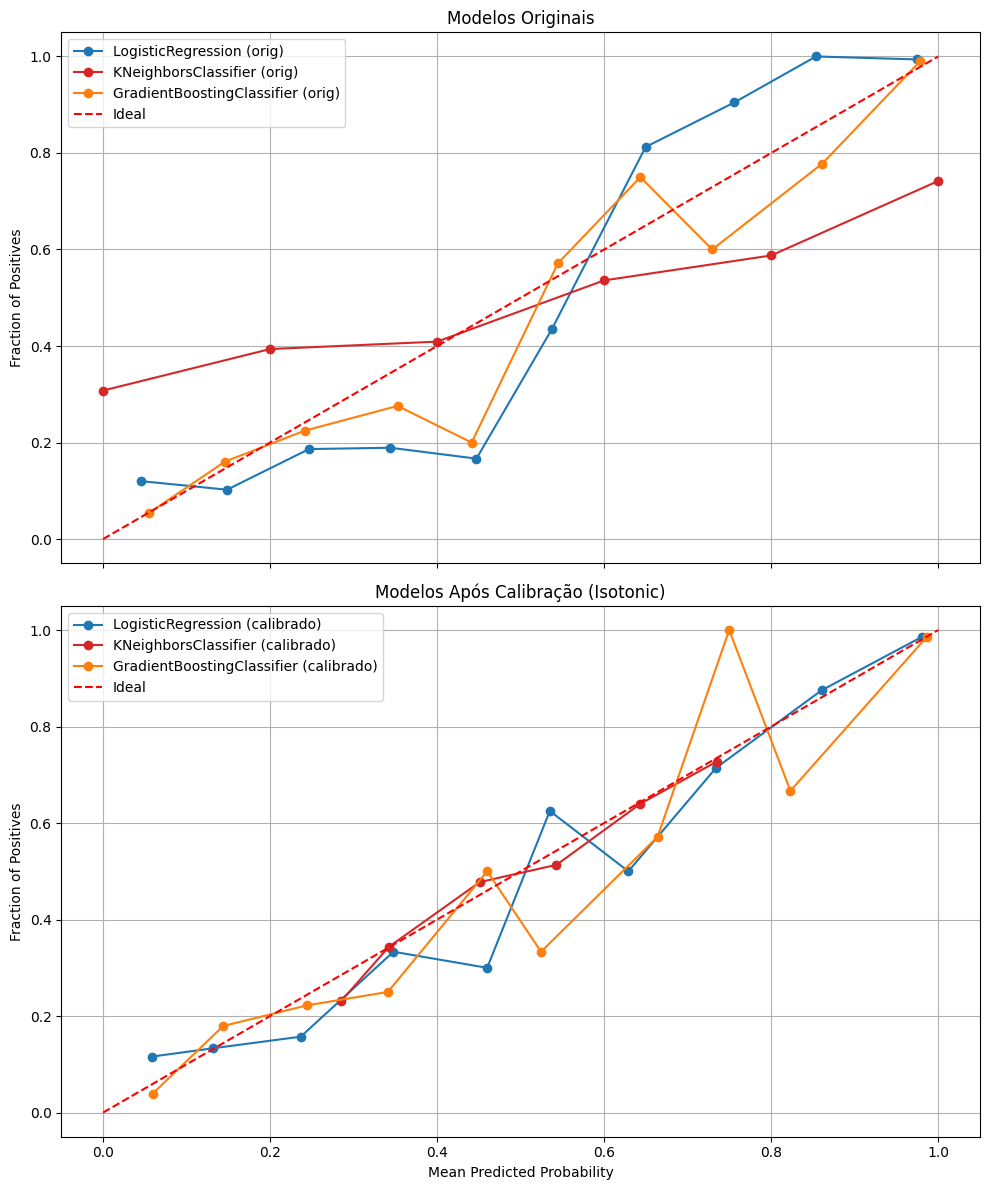


 Tabela Comparativa de Brier Scores (ordenada):
                    Modelo  Antes         Depois
GradientBoostingClassifier 0.0801  0.0792 (1.2%)
        LogisticRegression 0.0972  0.0896 (7.8%)
      KNeighborsClassifier 0.2677 0.2343 (12.5%)


In [28]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss

# Carregar os dados
col_names = [f'X{i}' for i in range(1, 12)] + ['y']
df_train = pd.read_csv('data/credtrain.txt', sep=r'\s+', header=None, names=col_names)
df_test = pd.read_csv('data/credtest.txt', sep=r'\s+', header=None, names=col_names)

X_train, y_train = df_train.drop('y', axis=1), df_train['y']
X_test, y_test = df_test.drop('y', axis=1), df_test['y']

# Modelos base
models = {
    'LogisticRegression': LogisticRegression(max_iter=5000, solver='lbfgs'), 
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()
}

# Cores com bom contraste
colors = {
    'LogisticRegression': '#1f77b4',   # Azul escuro
    'KNeighborsClassifier': '#d62728', # Vermelho forte
    'GradientBoostingClassifier': '#ff7f0e'  # Laranja
}

# Para armazenar brier scores
brier_scores = {'Modelo': [], 'Antes': [], 'Depois': []}

# Preparar figura com 2 subplots verticais
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Modelos Originais
for name, model in models.items():
    model.fit(X_train, y_train)
    prob_pos = model.predict_proba(X_test)[:, 1]
    frac_pos, mean_pred = calibration_curve(y_test, prob_pos, n_bins=10)
    axes[0].plot(mean_pred, frac_pos, marker='o', color=colors[name], label=f'{name} (orig)')
    brier_before = brier_score_loss(y_test, prob_pos)
    brier_scores['Modelo'].append(name)
    brier_scores['Antes'].append(brier_before)

axes[0].plot([0, 1], [0, 1], 'r--', label='Ideal')
axes[0].set_title('Modelos Originais')
axes[0].set_ylabel('Fraction of Positives')
axes[0].legend()
axes[0].grid(True)

# Modelos Calibrados
for name, model in models.items():
    calibrated = CalibratedClassifierCV(model, method='isotonic', cv=5)
    calibrated.fit(X_train, y_train)
    prob_cal = calibrated.predict_proba(X_test)[:, 1]
    frac_pos, mean_pred = calibration_curve(y_test, prob_cal, n_bins=10)
    axes[1].plot(mean_pred, frac_pos, marker='o', color=colors[name], label=f'{name} (calibrado)')
    brier_after = brier_score_loss(y_test, prob_cal)
    brier_scores['Depois'].append(brier_after)

axes[1].plot([0, 1], [0, 1], 'r--', label='Ideal')
axes[1].set_title('Modelos Após Calibração (Isotonic)')
axes[1].set_xlabel('Mean Predicted Probability')
axes[1].set_ylabel('Fraction of Positives')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("calibracao_modelos.png", dpi=300)
plt.show()

# Dataframe para Brier Scores
df_brier = pd.DataFrame(brier_scores)
df_brier = df_brier.sort_values(by='Depois')

# Adicionar cálculo do ganho relativo
df_brier['Ganho Relativo (%)'] = ((df_brier['Antes'] - df_brier['Depois']) / df_brier['Antes'] * 100).round(1)
df_brier['Depois'] = df_brier.apply(lambda row: f"{row['Depois']:.4f} ({row['Ganho Relativo (%)']:.1f}%)", axis=1)
df_brier['Antes'] = df_brier['Antes'].apply(lambda x: f"{x:.4f}")  # Formatar para 4 casas
df_brier = df_brier.drop(columns=['Ganho Relativo (%)'])

print("\n Tabela Comparativa de Brier Scores (ordenada):")
print(df_brier.to_string(index=False))



# (6) Validação cruzada aninhada

=== Resultados Detalhados ===
                    model  fold  test_r2                                                                                               best_params
         LinearRegression     1 0.918933                                                                            {'model__fit_intercept': True}
         LinearRegression     2 0.922248                                                                            {'model__fit_intercept': True}
         LinearRegression     3 0.914099                                                                            {'model__fit_intercept': True}
         LinearRegression     4 0.919603                                                                            {'model__fit_intercept': True}
         LinearRegression     5 0.923143                                                                            {'model__fit_intercept': True}
GradientBoostingRegressor     1 0.980111 {'model__subsample': 1.0, 'model__n_estimators'

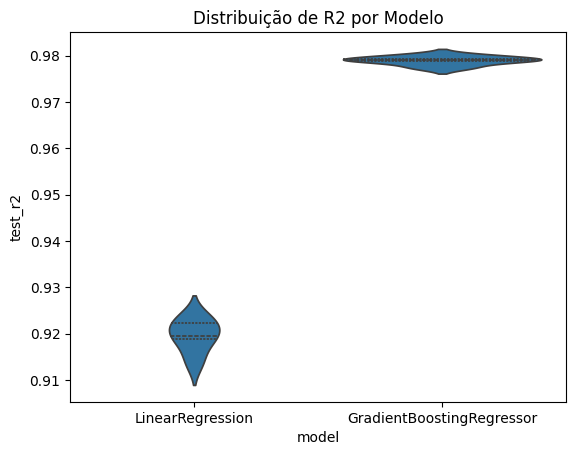

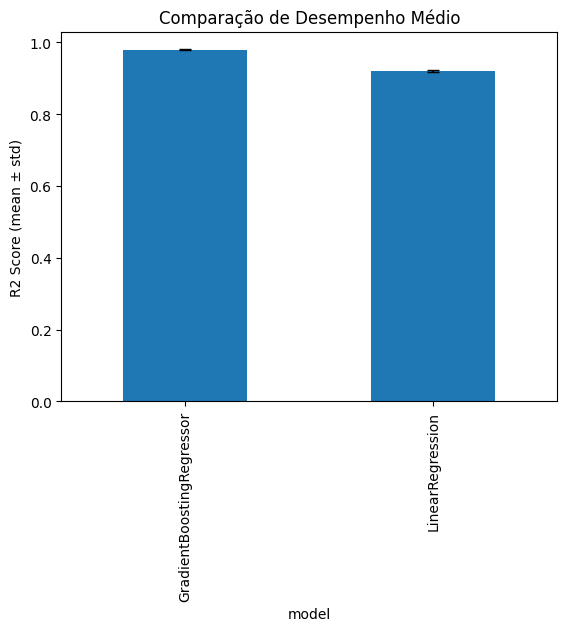

In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def load_data(path):
    df = pd.read_csv(path)
    X = df.drop('price', axis=1)
    y = df['price'].values
    return X, y

def build_pipeline(categorical_features, numeric_features):
    # ColumnTransformer para pré-processamento
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features),
        ('std', StandardScaler(), numeric_features['standard']),
        ('robust', RobustScaler(), numeric_features['robust']),
        ('minmax', MinMaxScaler(), numeric_features['minmax'])
    ], remainder='drop')

    # Pipelines para cada estimador
    pipe_lr = Pipeline([
        ('preproc', preprocessor),
        ('model', LinearRegression())
    ])
    pipe_gbr = Pipeline([
        ('preproc', preprocessor),
        ('model', GradientBoostingRegressor(random_state=42))
    ])

    return pipe_lr, pipe_gbr

def nested_cv(X, y, pipe_lr, pipe_gbr, numeric_features, categorical_features):
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    # Grid e Randomized Search
    lr_param_grid = {
        'model__fit_intercept': [True, False]
    }
    gbr_param_dist = {
        'model__n_estimators': [100, 200, 300, 400],
        'model__max_depth': [3, 4, 5, 6],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__subsample': [0.6, 0.8, 1.0]
    }

    lr_search = GridSearchCV(pipe_lr, lr_param_grid, cv=inner_cv, scoring='r2', n_jobs=-1)
    gbr_search = RandomizedSearchCV(pipe_gbr, gbr_param_dist, 
                                    n_iter=10, cv=inner_cv, scoring='r2', 
                                    random_state=42, n_jobs=-1)

    results = []
    for name, search in [('LinearRegression', lr_search), ('GradientBoostingRegressor', gbr_search)]:
        for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            search.fit(X_train, y_train)
            best = search.best_estimator_
            preds = best.predict(X_test)
            score = r2_score(y_test, preds)

            results.append({
                'model': name,
                'fold': fold,
                'test_r2': score,
                'best_params': search.best_params_
            })

    results_df = pd.DataFrame(results)
    summary = results_df.groupby('model')['test_r2'].agg(['mean', 'std'])
    return results_df, summary

def main():
    data_path = 'data/diamonds.csv'
    cat_features = ['cut', 'color', 'clarity']
    num_features = {
        'standard': ['depth', 'table'],
        'robust': ['carat'],
        'minmax': ['x', 'y', 'z']
    }

    X, y = load_data(data_path)
    pipe_lr, pipe_gbr = build_pipeline(cat_features, num_features)
    results_df, summary = nested_cv(X, y, pipe_lr, pipe_gbr, num_features, cat_features)

    print("=== Resultados Detalhados ===")
    print(results_df.to_string(index=False))
    print("\n=== Resumo de Desempenho ===")
    print(summary)

    # Violin plot e bar plot com erro
    import seaborn as sns
    plt.figure()
    sns.violinplot(x='model', y='test_r2', data=results_df, inner='quartile')
    plt.title('Distribuição de R2 por Modelo')
    plt.show()

    summary['mean'].plot.bar(yerr=summary['std'], capsize=4)
    plt.ylabel('R2 Score (mean ± std)')
    plt.title('Comparação de Desempenho Médio')
    plt.show()

if __name__ == '__main__':
    main()
